In [1]:

import os 
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import random

pd.options.mode.chained_assignment = None

# =============================================================================
# # Import odds
# =============================================================================
df_odds = pd.read_csv('odds.csv')



In [2]:

# =============================================================================
# # Task 1 - Which team won the league in season 1? 
# =============================================================================

def preprocessing():
    """Process the results data to obtain Homewin, AwayWin Draw and team features 
    requires the df_results and df_teams"""
    
    results = pd.read_csv('results.csv')
    teams = pd.read_csv('teams.csv')
    # Match the team names with the results table 
    results = results.merge(teams, left_on='HomeTeamID', right_on='TeamID')
    results = results.merge(teams, left_on='AwayTeamID', right_on='TeamID')
    results = results.rename(columns = {'TeamName_x' : 'Home', 'TeamName_y':'Away'})
    del results['TeamID_x'], results['TeamID_y']
    
    # Create a separation in home, away wins and draws 
    results['HomeWin'] = results['HomeScore'] > results['AwayScore']
    results['AwayWin'] = results['HomeScore'] < results['AwayScore']
    results['Draw'] = results['HomeScore'] == results['AwayScore']
    
    return results

    
df_results = preprocessing()


def obtain_points(results_df, side):
    """Calculates the points won for Home/Away outcomes of matches
    results_df = results table
    side = str of Home/Away"""
    
    points = results_df[results_df[side +'Win'] == True]
    points['Points_Won_' + side] = 3
    points = points.groupby([side])['Points_Won_' + side].sum().to_frame()
    
    return points 



def standings(results_df):
    """Calculates the points obtained given a dataframe with match results
    results_df: results.csv with some modifications  as an argument"""

    home_points = obtain_points(results_df, 'Home')
    away_points = obtain_points(results_df, 'Away')
    draw_points_h = results_df[(results_df['Draw'] == True)].groupby(['Home'])['Gameweek'].count().to_frame()
    draw_points_w = results_df[(results_df['Draw'] == True)].groupby(['Away'])['Gameweek'].count().to_frame()

    # Bring all the points won together 
    total_points = home_points.merge(away_points, left_index = True, right_index = True)
    total_points = total_points.merge(draw_points_h, left_index = True, right_index = True)
    total_points = total_points.merge(draw_points_w, left_index = True, right_index=True, suffixes = ['_Home', '_Away'])
    
    # Calculate total points won, sort and output the winner of the league 
    total_points['TOTAL_POINTS'] = total_points['Points_Won_Home'] + total_points['Points_Won_Away'] + total_points['Gameweek_Home'] + total_points['Gameweek_Away'] 
    total_points = total_points.sort_values(by = ['TOTAL_POINTS'], ascending = False)

    return total_points 

end_of_season_standings = standings(df_results[df_results['SeasonID'] == 1])

# Create end of season table with points and rankings 
end_of_season_standings = end_of_season_standings.reset_index()
end_of_season_standings = end_of_season_standings.reset_index()

end_of_season_standings = end_of_season_standings.rename(columns = {'level_0' : 'RANK', 'index' : 'TeamName'})
end_of_season_standings['RANK'] = end_of_season_standings['RANK'] + 1 

print('Task 1. Which team won the league in Season 1?')
print("The winner in Season 1 is " + str(end_of_season_standings.TeamName[0]) + " with " + str(end_of_season_standings['TOTAL_POINTS'].max()) + " points.")




Task 1. Which team won the league in Season 1?
The winner in Season 1 is Miami with 138 points.


In [8]:

# =============================================================================
# # Task 2 - At what point in the season did that team secure their league title?
# =============================================================================

    
def gameweek_tables(season):
    
    results = pd.read_csv('results.csv')
    teams = pd.read_csv('teams.csv')
    
    # Match the team names with the results table 
    results = results.merge(teams, left_on='HomeTeamID', right_on='TeamID')
    results = results.merge(teams, left_on='AwayTeamID', right_on='TeamID')
    results = results.rename(columns = {'TeamName_x' : 'Home', 'TeamName_y':'Away'})
    del results['TeamID_x'], results['TeamID_y']
    
    # Create a separation in home, away wins and draws 
    results['HomeWin'] = results['HomeScore'] > results['AwayScore']
    results['AwayWin'] = results['HomeScore'] < results['AwayScore']
    results['Draw'] = results['HomeScore'] == results['AwayScore']
    
    results = results[results['SeasonID'] == season]
    
    
    # Create the league table at the beginning of the season 
    teams_names = list(results['Home'].unique())
    league_table = teams['TeamName'].to_frame() 
    league_table['Points'] = 0 
    league_table['Games_Played'] = 0
    league_table['Games_Remaining'] = 54
    league_table['Points_Available'] = 54 * 3  
    league_table = league_table.set_index('TeamName')
    
    # New stats in the league table 
    league_table['Goals_Scored'] = 0
    league_table['Goals_Conceded'] = 0 
    
    weeks_as_champions = []
    
    weekly_league_table = []
    
    recent_form = teams
    del recent_form['TeamID']
    recent_form.columns = ['Team']
    
    for gameweek in range(1, results['Gameweek'].max() + 1):
        
        games = results[results['Gameweek'] == gameweek]
        
        if 'RANK' in league_table.columns:
            del league_table['RANK']
            
        # Obtain points for the winners Home/Away 3 points 
        home_p = obtain_points(games, 'Home')
        home_p.columns = ['Points_Won']
        away_p = obtain_points(games, 'Away')
        away_p.columns = ['Points_Won']
        
        # Obtain points for draws Home/Away 1 point 
        draw_home = games[(games['Draw'] == True)].groupby(['Home'])['Gameweek'].count().to_frame()
        draw_home.columns = ['Points_Won']
        draw_away = games[(games['Draw'] == True)].groupby(['Away'])['Gameweek'].count().to_frame()
        draw_away.columns = ['Points_Won']
        
        # Create table with the home/away points for winners and the draws 
        week_table = pd.concat([home_p,away_p, draw_home, draw_away])
        
        # Obtain the losers and assign 0 points to them 
        teams_index = list(week_table.index)
        losers = [team for team in teams_names if team not in teams_index]
        loser_points = [0 for loser in losers]
        losers = dict(zip(losers, loser_points))
        losers = pd.DataFrame(losers, index=[0]).transpose()
        losers.columns = ['Points_Won']
        
        
        # Create a table for the gameweek - n 
        week_table = pd.concat([home_p,away_p, draw_home, draw_away, losers])
        week_table = week_table.reset_index()
        week_table.columns = [ 'Team' ,'Points_Won_Week_' + str(gameweek)]
        
        # Create goals features 
        
        home_goals = games[['Home', 'HomeScore', 'AwayScore']]
        home_goals.columns = ['Team', 'Home_goals_scored', "Home_goals_conceded"]
        
        away_goals = games[['Away', 'AwayScore', 'HomeScore']]
        away_goals.columns = ['Team', 'Away_goals_scored', "Away_goals_conceded"]
    
        week_table = week_table.merge(home_goals, on = 'Team', how = 'left')
        week_table = week_table.merge(away_goals, on = 'Team', how = 'left' )
        week_table = week_table.fillna(0)
        week_table['Goals_Scored_Week_' + str(gameweek)] = week_table['Home_goals_scored']  + week_table['Away_goals_scored']
        week_table['Goals_Conceded_Week_' + str(gameweek)] = week_table['Home_goals_conceded']  + week_table['Away_goals_conceded']
        
        del week_table['Home_goals_scored'], week_table['Home_goals_conceded'], week_table['Away_goals_scored'], week_table['Away_goals_conceded']
        
        # Update the league table with the gameweek table for goals scored etc
        if gameweek < 2:
        
            league_table = league_table.reset_index()
            league_table = league_table.rename(columns = {'TeamName' : 'Team'})
        
        league_table = league_table.merge(week_table, on = 'Team')
        league_table['Points'] = league_table['Points'] + league_table['Points_Won_Week_' + str(gameweek)]
        league_table['Points_Available'] = league_table['Points_Available'] - 3 
        league_table['Games_Played'] = gameweek 
        league_table['Games_Remaining'] = 54 - gameweek 
        league_table = league_table.sort_values(by = ['Points', 'Goals_Scored'], ascending = False)
        
        del league_table['Points_Won_Week_' + str(gameweek)]
        
        # Find the points difference between the places i.e. 1st to second points difference 
        league_table['POINTS_DIFFERENCE'] = league_table['Points'].diff()
        league_table['POSITION_SECURED'] = league_table['Points_Available'] < abs(league_table['POINTS_DIFFERENCE'])
        
        # Update goals scored, etc 
        league_table['Goals_Scored'] = league_table['Goals_Scored'] + league_table['Goals_Scored_Week_' + str(gameweek)]
        league_table['Goals_Conceded'] = league_table['Goals_Conceded'] + league_table['Goals_Conceded_Week_' + str(gameweek)]
        del league_table['Goals_Scored_Week_' + str(gameweek)], league_table['Goals_Conceded_Week_' + str(gameweek)]
        
        # Create goals per game features 
        league_table['Goals_Scored_x_game'] = league_table['Goals_Scored'] / league_table['Games_Played']
        league_table['Goals_Conceded_x_game'] = league_table['Goals_Conceded'] / league_table['Games_Played']
        
        league_table = league_table.fillna(0)
        
        # Create rankings feature
        league_table = league_table.sort_values(by = ['Points', 'Goals_Scored', 'Goals_Conceded'], ascending = False)
        league_table = league_table.reset_index()
        del league_table['index']
        league_table = league_table.reset_index()
        league_table = league_table.rename(columns = {'index' : 'RANK'})
        league_table['RANK'] = league_table['RANK'] + 1     
        
        
        # Create recent form feature - the points obtained from the last 5 games 
        update = week_table[week_table.columns[0:2].to_list()]
        recent_form = recent_form.merge(update, on = 'Team')
        
        if 'RECENT_FORM_L5' in recent_form.columns:
            
            del recent_form['RECENT_FORM_L5']
        
        if len(recent_form.columns) > 6:
            del recent_form[recent_form.columns[1]]
        
        recent_form['RECENT_FORM_L5'] = recent_form.sum(axis=0)
        
        new_form = recent_form[['Team', 'RECENT_FORM_L5']]
        
        if 'RECENT_FORM_L5' in league_table.columns:
            
            del league_table['RECENT_FORM_L5']
        
        league_table = league_table.merge(new_form, on = 'Team') 
        
        
        # Keep track of points differences between the places to find out when the title is secured      
        secured_positions = list(league_table['POSITION_SECURED'])
        
        weekly_league_table.append(league_table)

        
        if secured_positions[1] == True:
            weeks_as_champions.append(gameweek)
    
    if season == 1:
        
        print('')
        print('Task 2.At what point in the season did that team secure their league title?')
        print(str(league_table.Team[0]) + " secure the title in Gameweek " + str(weeks_as_champions[0]) + ' in Season ' + str(season))
        # Miami become champions in Gameweek 50 for season 1 and in Gameweek 52 for season 2 
    return weekly_league_table





season_1 = gameweek_tables(1)
season_2 = gameweek_tables(2)



Task 2.At what point in the season did that team secure their league title?
Miami secure the title in Gameweek 50 in Season 1
Index(['RANK', 'Team', 'Points', 'Games_Played', 'Games_Remaining',
       'Points_Available', 'Goals_Scored', 'Goals_Conceded',
       'POINTS_DIFFERENCE', 'POSITION_SECURED', 'Goals_Scored_x_game',
       'Goals_Conceded_x_game', 'RECENT_FORM_L5'],
      dtype='object')
Index(['RANK', 'Team', 'Points', 'Games_Played', 'Games_Remaining',
       'Points_Available', 'Goals_Scored', 'Goals_Conceded',
       'POINTS_DIFFERENCE', 'POSITION_SECURED', 'Goals_Scored_x_game',
       'Goals_Conceded_x_game', 'RECENT_FORM_L5'],
      dtype='object')


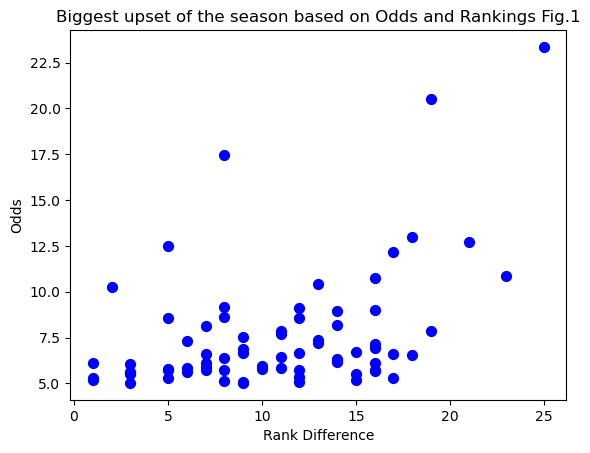


Task 3. What result was the biggest upset?
The biggest upset is the draw between Miami and Milwaukee which is evident from the odds of 23.35 for a draw and the rank difference at the end of the season where the two teams are separated by 25 places (right top corner in Fig.1)

    Gameweek           Home       Away  HomeScore  AwayScore   ODDS  \
54        12          Miami  Milwaukee          3          3  23.35   
50        28          Miami    Atlanta          1          1  20.52   
68        52      Arlington    Houston          0          1  17.44   
10         2  San Francisco     Boston          2          1  13.01   
72        38     New York S  San Diego          2          2  12.72   

    RANK_DIFFERENCE  
54               25  
50               19  
68                8  
10               18  
72               21  


In [9]:

# =============================================================================
# # Task 3. What result was the biggest upset?
# =============================================================================

def biggest_upsets(results, odds_df, eos_table):

    odds_df.columns = ['MatchID', 'Home_odds', 'Draw_odds', 'Away_odds']
    results = results.merge(odds_df, on = 'MatchID')
    
    # Filtering the data for highly unlikely outcomes with odds > 5 
    home_upsets = results[(results['HomeWin'] == True) & (results['Home_odds'] > 5)]
    away_upsets = results[(results['AwayWin'] == True) & (results['Away_odds'] > 5)]
    draws_upsets = results[(results['Draw'] == True) & (results['Draw_odds'] > 5)]
    
    # Create an odds column 
    home_upsets['ODDS'] = home_upsets['Home_odds']
    away_upsets['ODDS'] = away_upsets['Away_odds']
    draws_upsets['ODDS'] = draws_upsets['Draw_odds']
    
    # Create a unified table with the odds of the outcome of the game
    odds = pd.concat([home_upsets, away_upsets, draws_upsets], axis = 0)
    
    # Obtain the end of seasons rankings from the end_of_season_stadning table in 1 
    rank = eos_table[['TeamName', 'RANK']]
    
    odds = odds.merge(rank, left_on = 'Home', right_on = 'TeamName')
    odds = odds.merge(rank, left_on = 'Away', right_on = 'TeamName')
    odds['RANK_DIFFERENCE'] = abs(odds['RANK_x'] - odds['RANK_y'])
    odds = odds.sort_values(by = ['ODDS', 'RANK_DIFFERENCE'], ascending = False)
    
    # Plot the upsets based on end of season rankings and odds of the outcome         
    plt.scatter(odds['RANK_DIFFERENCE'], odds['ODDS'], color = 'b', s = 50)
    plt.ylabel('Odds')
    plt.xlabel('Rank Difference')
    plt.title('Biggest upset of the season based on Odds and Rankings Fig.1')
    plt.savefig('Part1 - Task 3.png')
    plt.show()
    plt.close()
    
    text = """The biggest upset is the draw between Miami and Milwaukee which is evident from the odds of 23.35 for a draw and the rank difference at the end of the season where the two teams are separated by 25 places (right top corner in Fig.1)"""
    
    odds = odds[['Gameweek', 'Home', 'Away', 'HomeScore', 'AwayScore', 'ODDS', 'RANK_DIFFERENCE']]
    
    print('')
    print('Task 3. What result was the biggest upset?')
    print(text)
    print('')
    print(odds.head())
    
    return odds.head()


df_results = preprocessing()

upset = biggest_upsets(df_results[df_results['SeasonID'] == 1], df_odds, end_of_season_standings)


In [10]:

# =============================================================================
# ##### Part 2 ##### Predicting the second season 
# =============================================================================

# =============================================================================
# # Task 4 Predicting the second season
# =============================================================================
print('')
print('Task 4: There are many methods that can be used for predicting the outcomes of football matches. Choose and implement one, and use it to generate predictions for the forthcoming season. Consider how you might test this model, bearing in mind you have results available for the second season.')
print('')

def create_data_for_season_n(results_df, odds_df, season_n, season_tables):
    """
    Creates a dataset to be used as input for training/testing a Machine Learning model
    Accepts:
    df_results: (after preprocessing) dataframe to create the fixtures
    odds_df: odds data to attach to the fixtures
    season_n = int for season 1 or 2 
    season_tables: the list of weekly tables returned from gameweek_tables()
    """

    mdl_features = ['RANK', 'Team', 'Gameweek' ,'Goals_Scored_x_game', 'Goals_Conceded_x_game',
                'RECENT_FORM_L5', 'POINTS_DIFFERENCE']

    
    conditions = [
            (results_df['HomeWin'] == True),
            (results_df['Draw'] == True),
            (results_df['AwayWin'] == True)
            ]
    
    
    values = ['HomeWin', 'Draw', 'AwayWin']
    
    
    results_df['Label'] = np.select(conditions, values)
    
    # Adding the odds 
    results_df = results_df.merge(odds_df, on = 'MatchID')
    results_df = results_df[results_df['SeasonID'] == season_n]
    
    
    # Create a training dataset from season 1 
    df = pd.DataFrame()
    
    for data in season_tables:
        
        # Process the rankings feature
        if 'RANK' in data.columns:
            del data['RANK']
        
        data = data.reset_index()    
        
        data = data.rename(columns = {'index' : 'RANK', 'Games_Played' : 'Gameweek'})
        data['RANK'] = data['RANK'] + 1     
        
        data = data[mdl_features]
        
        # Gameweek T - 1 features predict the outcomes for week T
        data['Gameweek'] = data['Gameweek'] + 1 
        
        # Create fixtures from the results dataframe 
        fixtures = results_df[['Gameweek', 'Home', 'Away', 'Home_odds',
                               'Draw_odds', 'Away_odds', 'Label']]
        
        fixtures = fixtures[fixtures['Gameweek'] == data['Gameweek'].max()]
        
        del data['Gameweek']
        
        # Merge the model features with the fixtures 
        fixtures = fixtures.merge(data, left_on = 'Home', right_on = 'Team')
        del fixtures['Team']
        
        fixtures = fixtures.merge(data, left_on = 'Away', right_on = 'Team', suffixes = ['_Home', '_Away'])
        del fixtures['Team']
    
        df = pd.concat([df, fixtures], axis = 0)

    return df


def features_formatting(train, odds = True):
    
    df_teams = pd.read_csv('teams.csv')
    
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_df = pd.DataFrame(encoder.fit_transform(df_teams[['TeamName']]).toarray())
    df_teams = df_teams.join(encoder_df)
    
    train = train.merge(df_teams, left_on = 'Home', right_on = 'TeamName' )
    train = train.merge(df_teams, left_on = 'Away', right_on = 'TeamName', suffixes = ['_Home', '_Away'] )
    
    train_labels = train[['Label']]
    
    del train['Label'], train['TeamName_Home'], train['TeamName_Away'], train['Home'], train['Away'], train['Gameweek']
    del train['TeamID_Home'], train['TeamID_Away']
    
    if odds == False:
        
        del train['Home_odds'], train['Away_odds'], train['Draw_odds']
    
    return train, train_labels


# Create Training, Validation and Test datasets 
training = create_data_for_season_n(df_results, df_odds, 1, season_1)
training = training[training['Gameweek'] >= 4 ]


training1 = training[training['Gameweek'] <= 46]
df_train, train_labels = features_formatting(training1, odds = True)

df_test = create_data_for_season_n(df_results, df_odds, 2, season_2)

val = training[training['Gameweek'] > 46]


df_val, val_labels = features_formatting(val, odds = True)
df_test, test_labels = features_formatting(df_test, odds = True)

del df_train['RECENT_FORM_L5_Home'], df_train['RECENT_FORM_L5_Away']
del df_test['RECENT_FORM_L5_Home'], df_test['RECENT_FORM_L5_Away']
del df_val['RECENT_FORM_L5_Home'], df_val['RECENT_FORM_L5_Away']
# Model Building 
print('')
print('Start Random Forests Model Building...')
clf = RandomForestClassifier(n_estimators = 100, max_depth = 200)
clf.fit(df_train.values, train_labels.values.ravel())

print('')
print('Building model with features: Most recent ranking, Average goals scored per game, Average goals conceded per game, Recent form (points from last 5 matches) and Points difference to the next closest position in the league table  ')

print('')
print('Model building finished')

# Cross Validation 
print('')
print('Cross Validation Model Building and Testing in progress...')
print('')
cv = cross_val_score(clf, df_train.values, train_labels.values.ravel(), cv = 5)
print('Cross Validation Finished')

# Model Evaluation and Predictions  
predictions = pd.DataFrame(clf.predict(df_test.values), columns = ['Predictions'])
probs = pd.DataFrame(clf.predict_proba(df_test.values), columns = ['AwayWin_Prob', 'Draw_Prob', 'HomeWin_Prob'])
predictions = predictions.join(probs)
del probs 

# Print Classification report
print('')
print('Test Set Classification report:')
print('')
print(classification_report(test_labels.values , predictions.Predictions.values, target_names = ['HomeWin', 'Draw', 'AwayWin']))

# Accuracy 
print('')
print( 'Training Set Accuracy: ' + str(clf.score(df_train.values, train_labels.values)))
print( 'Average Accuracy of Cross Validation models: ' + str(round(cv.mean(),4)))
print( 'Validation Set Accuracy: ' + str(round(clf.score(df_val.values, val_labels.values), 4)))
print( 'Test Set Accuracy: ' + str(round(clf.score(df_test.values, test_labels.values), 4)))

del training, training1, upset, val, val_labels, train_labels, df_val, df_train 
print('Model performance: model is not optimized and it is currently overfitting.')



Task 4: There are many methods that can be used for predicting the outcomes of football matches. Choose and implement one, and use it to generate predictions for the forthcoming season. Consider how you might test this model, bearing in mind you have results available for the second season.


Start Random Forests Model Building...

Building model with features: Most recent ranking, Average goals scored per game, Average goals conceded per game, Recent form (points from last 5 matches) and Points difference to the next closest position in the league table  

Model building finished

Cross Validation Model Building and Testing in progress...

Cross Validation Finished

Test Set Classification report:

              precision    recall  f1-score   support

     HomeWin       0.56      0.63      0.59       249
        Draw       0.23      0.11      0.15       138
     AwayWin       0.68      0.75      0.71       355

    accuracy                           0.59       742
   macro avg      


Task 5 Produce a visualisation showing how likely you predict each team is to finish in each position.

Starting a Monte Carlo Simulation to obtain the probabilities for the end of year standings for each team...

Monte Carlo Simulation Completed



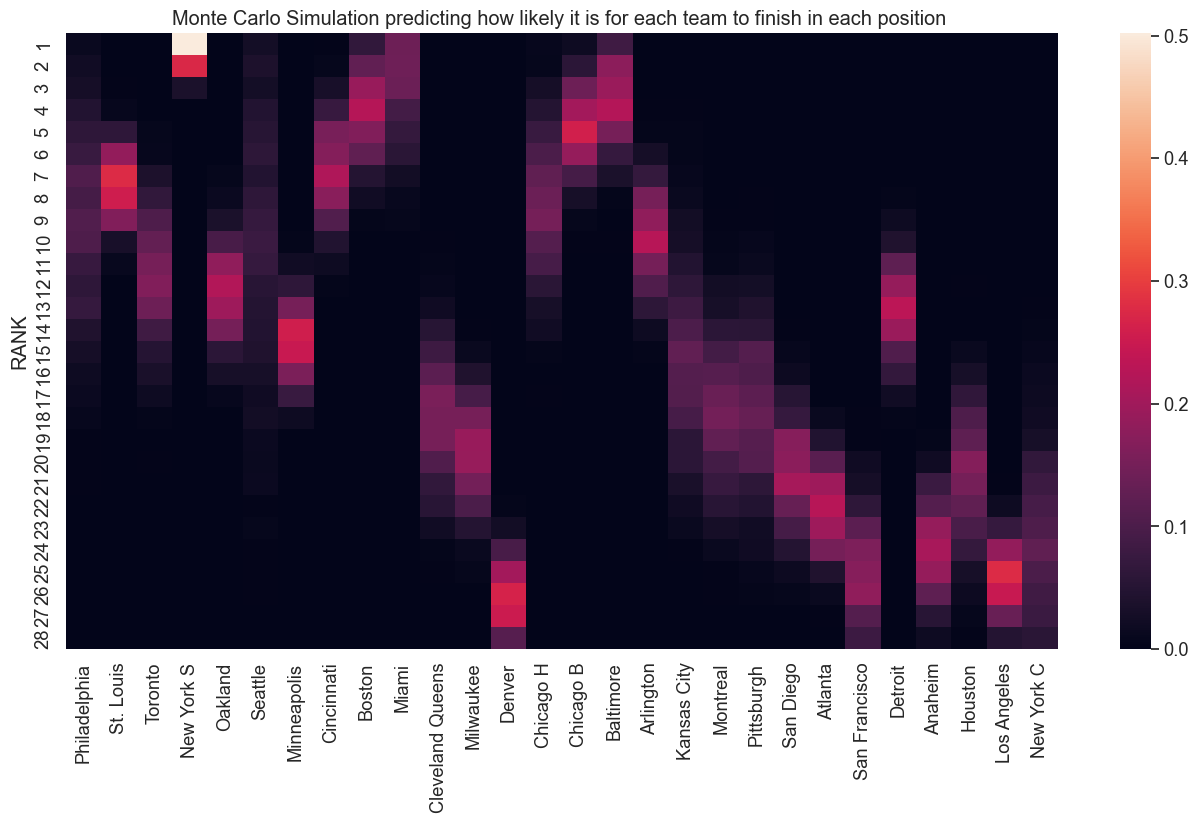

In [11]:

# =============================================================================
# Task 5 Produce a visualisation showing how likely you predict each team is to finish in each position.
# =============================================================================

print('')
print('Task 5 Produce a visualisation showing how likely you predict each team is to finish in each position.')

# =============================================================================
# FORMATTING AND WRANGLING 
# =============================================================================
df_teams = pd.read_csv('teams.csv')
teams_list = list(df_teams['TeamName'])

for i in range(0,28):
    
    df_test = df_test.rename(columns = {str(i) + '_Home' : teams_list[i] + '_Home',
                                        str(i) + '_Away' : teams_list[i] + '_Away'})

    
del i 


labels = predictions.join(test_labels)
df_test = df_test.join(labels)
df_test = df_test.merge(df_odds, on = ['Home_odds', 'Away_odds', 'Draw_odds'])
df_fixtures = pd.read_csv('fixtures.csv')
df_test = df_test.merge(df_fixtures, on = 'MatchID')

df_test = df_test.merge(df_teams, left_on = 'HomeTeamID', right_on = 'TeamID')
df_test = df_test.merge(df_teams, left_on = 'AwayTeamID', right_on = 'TeamID', suffixes = ['_Home', '_Away'])


del df_test['TeamID_Away'], df_test['TeamID_Home'], df_test['HomeTeamID'], df_test['AwayTeamID'], cv

########################################################################################

home_pred = df_test[df_test['Predictions'] == 'HomeWin']
away_pred = df_test[df_test['Predictions'] == 'AwayWin']
draw_pred = df_test[df_test['Predictions'] == 'Draw']

home_pred['Pred_Prob'] = home_pred['HomeWin_Prob'] 
away_pred['Pred_Prob'] = away_pred['AwayWin_Prob'] 
draw_pred['Pred_Prob'] = draw_pred['Draw_Prob'] 

df_test = pd.concat([home_pred, away_pred, draw_pred], axis = 0)


conditions = [(df_test['Predictions'] =='HomeWin'),
              (df_test['Predictions'] == 'Draw'),
              (df_test['Predictions'] == 'AwayWin') ]
    
values = [3 , 1 , 0 ] 


df_test['HomePoints'] = np.select(conditions, values)

values = [0 , 1 , 3] 

df_test['AwayPoints'] = np.select(conditions, values)

del away_pred, home_pred, draw_pred


home_pred = df_test[df_test['Label'] == 'HomeWin']
away_pred = df_test[df_test['Label'] == 'AwayWin']
draw_pred = df_test[df_test['Label'] == 'Draw']

home_pred['ODDS'] = home_pred['HomeWin_Prob'] 
away_pred['ODDS'] = away_pred['AwayWin_Prob'] 
draw_pred['ODDS'] = draw_pred['Draw_Prob'] 

df_test = pd.concat([home_pred, away_pred, draw_pred], axis = 0)

df_test['ODDS_AS_PCT'] = 100 / df_test['ODDS'] 


# =============================================================================
# MONTE CARLO SIMULATION 
# =============================================================================

teams = list(df_test['TeamName_Home'].unique())

print('')
print('Starting a Monte Carlo Simulation to obtain the probabilities for the end of year standings for each team...')
mc = {}

for team in teams:
    
    df_home = df_test[df_test['TeamName_Home'] == team]
    df_away = df_test[df_test['TeamName_Away'] == team]
    df = pd.concat([df_home, df_away], axis = 0)
    df['Team'] = team
    
    conditions = [(df['TeamName_Home'] == team), (df['TeamName_Away'] == team)]
    values = [df['RANK_Home'], df['RANK_Away']]
    
    df['RANK'] = np.select(conditions, values)
    
    
    avg_rank = round(df['RANK'].mean(), 4)
    std_rank = round(df['RANK'].std(), 4)
    
    simulated_positions = []
    
    for run in range(0,1000):
        
        probability = random.uniform(0,1)
    
        inverse_cdf = norm.ppf(probability, avg_rank, std_rank).astype(int)
    
        simulated_positions.append(inverse_cdf)

    mc[team] = simulated_positions


print('')
print('Monte Carlo Simulation Completed')
print('')

season_2_standings = season_2[-1].reset_index()
season_2_standings = season_2_standings.rename(columns = {'index' : 'RANK'})
season_2_standings['RANK'] = season_2_standings['RANK'] + 1 


mc = pd.DataFrame(mc)

prob_table = {}

for team in teams:
    
    team_rank = season_2_standings[season_2_standings['Team'] == team]['RANK']
    
    prob = sum(mc[team] == team_rank.iloc[0]) / 1000
    
    prob_table[team] = (team_rank.iloc[0], prob)


prob_table = pd.DataFrame(prob_table).transpose().reset_index()
prob_table.columns = ['Team', 'RANK', 'PROB(RANK)']
prob_table = prob_table.sort_values(by = 'RANK')

# PREDICT PROB FOR EACH POSITION FOR EACH TEAM USING 
prob_table1 = {}

for team in teams:
    
    positions = []
    
    for rank in range(1,29):
    
        prob = sum(mc[team] == rank) / 1000
        
        positions.append(prob)
        
    prob_table1[team] = positions
    
    

prob_table1 = pd.DataFrame(prob_table1).reset_index()
prob_table1['index'] = prob_table1['index'] + 1 
prob_table1 = prob_table1.set_index('index')

# Plot the results 
sns.set(rc = {'figure.figsize':(16,8)})
sns.set(font_scale=1.2)
ax = sns.heatmap(prob_table1)
plt.title('Monte Carlo Simulation predicting how likely it is for each team to finish in each position ')
plt.ylabel('RANK')

plt.savefig('Part2 - Task 2.png')

plt.show()

del df_home, df_away, conditions, values, avg_rank, inverse_cdf, positions, probability, rank, run, simulated_positions, std_rank, team,teams_list
del prob, prob_table,df, team_rank, test_labels, mc 



Task 6. Explore the data to your heart’s content



c:\Users\User\.conda\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\.conda\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\User\.conda\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\.conda\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You c

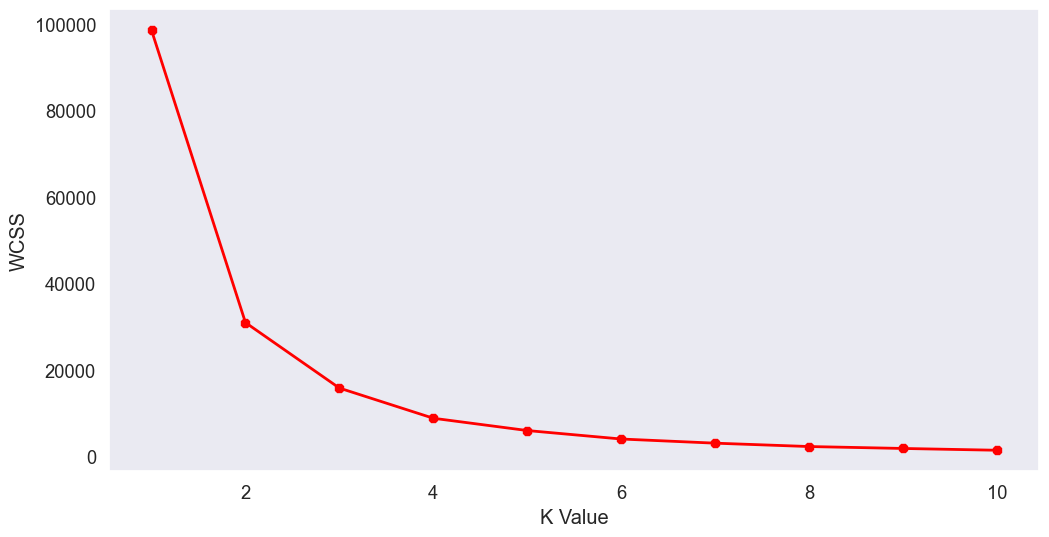

c:\Users\User\.conda\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\.conda\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(



Searching for anomalies in the matches of season 2...



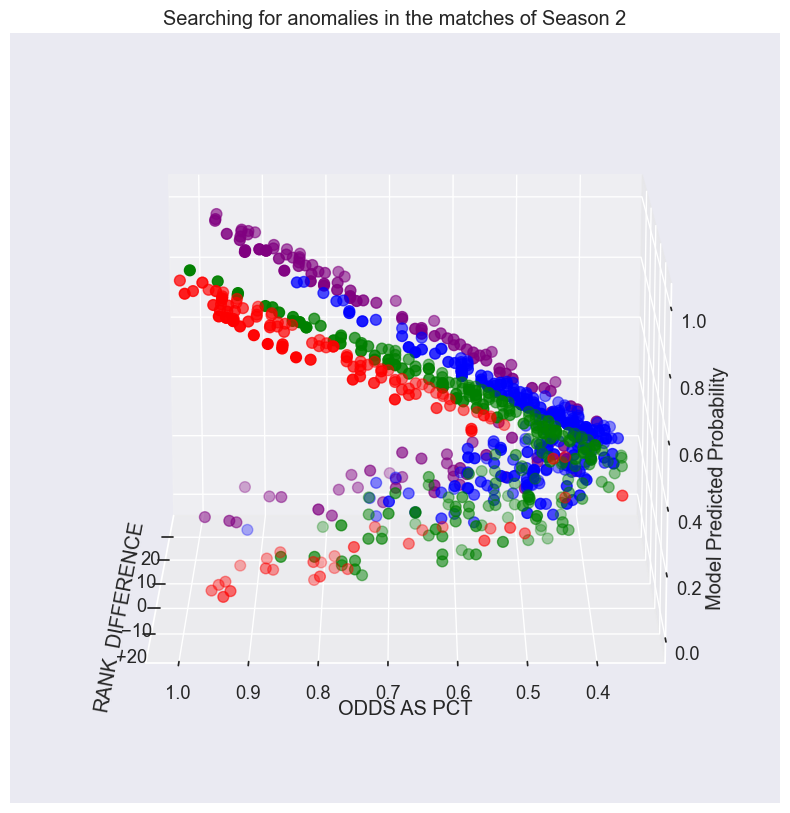

In [12]:

# =============================================================================
# TASK 6. ANYTHING ELSE 
# =============================================================================
print('')
print('Task 6. Explore the data to your heart’s content')
print('')


from sklearn.cluster import KMeans 

df_test['RANK_DIFFERENCE'] = df_test['RANK_Home'] - df_test['RANK_Away']

x1 = df_test[['ODDS', 'RANK_DIFFERENCE', 'Pred_Prob']].values

wcss = []

for k in range(1,11):
    
    kmeans = KMeans(n_clusters = k, init='k-means++')
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(x1)
    wcss.append(kmeans.inertia_)


plt.figure(figsize = (12,6))
plt.grid()
plt.plot(range(1,11), wcss, linewidth=2, color = 'red', marker = '8')
plt.xlabel('K Value')
plt.ylabel('WCSS')
plt.savefig('TASK6 - Number of Clusters.png')
plt.show()

# Create model with optimal number of clusters 
kmeans = KMeans(n_clusters = 4)
label = kmeans.fit_predict(x1)
df_test['KM_LABELS'] = label

print('')
print('Searching for anomalies in the matches of season 2...')
print('')

# Plot the clusters 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df_test['RANK_DIFFERENCE'][df_test['KM_LABELS'] == 0], df_test['Pred_Prob'][df_test['KM_LABELS'] == 0], df_test['ODDS'][df_test['KM_LABELS'] == 0], c = 'blue', s = 60 )
ax.scatter(df_test['RANK_DIFFERENCE'][df_test['KM_LABELS'] == 1], df_test['Pred_Prob'][df_test['KM_LABELS'] == 1], df_test['ODDS'][df_test['KM_LABELS'] == 1], c = 'red', s = 60 )
ax.scatter(df_test['RANK_DIFFERENCE'][df_test['KM_LABELS'] == 2], df_test['Pred_Prob'][df_test['KM_LABELS'] == 2], df_test['ODDS'][df_test['KM_LABELS'] == 2], c = 'green', s = 60 )
ax.scatter(df_test['RANK_DIFFERENCE'][df_test['KM_LABELS'] == 3], df_test['Pred_Prob'][df_test['KM_LABELS'] == 3], df_test['ODDS'][df_test['KM_LABELS'] == 3], c = 'purple', s = 60 )
ax.view_init(15,180)

plt.title('Searching for anomalies in the matches of Season 2')
plt.xlabel('RANK_DIFFERENCE')
plt.ylabel('ODDS AS PCT')
ax.set_zlabel('Model Predicted Probability')

plt.savefig('TASK6 - Clustering of the matches of the second season.png')

plt.show()



